<a href="https://colab.research.google.com/github/eunseochu/OB_10th/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **5) 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

**TMDB 5000 영화 데이터 세트** <br/>
유명한 영화 데이터 정보 사이트의 많은 영화 중 5000개의 영화에 대한 메타 정보를 새롭게 가공해 제공하는 데이터 세트

#### **5-1) 장르 속성을 이용한 영화 콘텐츠 기반 필터링** 
사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
- 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠를 기반으로 하는 방식
- 장르, 감독, 배우, 평점, 키워드, 영화 설명 등 영화에는 다양한 콘텐츠가 존재
  - 영화를 선택하는 데 중요한 요소인 영화 장르 속성을 기반으로 만들어보려 함
  - 장르 칼럼 값의 유사도를 비교한 뒤 그중 높은 평점을 가지는 영화를 추천하는 방식

#### **5-2) 데이터 로딩 및 가공**

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies =pd.read_csv('/content/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


- 4803개의 레코드와 20개의 피처로 구성
- 영화 제목, 개요, 인기도, 평점, 투표 수, 예산, 키워드 등 영화에 대한 다양한 메타 정보를 가짐
  - 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새롭게 DataFrame 생성
  - id, 영화제목 title, 영화가 속한 여러 가지 장르인 genrse, 평균 평점인 vote_average, <br/> 평점 투표 수인 vote_count, 영화의 인기를 나타내는 popularity, <br/> 영화를 설명하는 주요 키워드 문구인 keywords, 영화에 대한 개요 설명인 overview 추출

**칼럼 추출**

In [2]:
movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count',
                 'popularity', 'keywords', 'overview']]

- genres, keywords 등의 칼럼은 파이썬 리스트 내부에 여러 개의 딕셔너리가 있는 형태의 문자열로 표기됨
  - 한꺼번에 여러 개의 값을 표현하기 위한 표기 방식
  - genres의 경우 여러 가지 장르로 구성될 수 있기 때문
- 그러나 칼럼이 DataFrame으로 만들어질 때는 단순히 문자열 형태로 로딩되므로 가공해야 함

**genres, keywords 칼럼의 형태**

In [3]:
pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


- genres 칼럼은 여러 개의 개별 장르 데이터를 가지고 있고, 개별 장르의 명칭은 딕셔너리의 Key인 'name'으로 추출 가능
- Keywords 역시 마찬가지 구조를 가지고 있음

**genres, keywords 칼럼 1차 가공** <br/>
파이썬 ast 모듈의 literal_eval() 함수를 이용하면 이 문자열을 문자열을 의미하는 list[dic1, dic2] 객체로 만듦
- Series 객체의 apply()에 literal_eval() 함수를 적용해 문자열을 객체로 변환

In [4]:
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

- 이제 genres 칼럼은 문자열이 아니라 실제 리스트 내부에 여러 장르 딕셔너리로 구성된 객체를 가짐

**genres, keywords 칼럼 2차 가공** <br/>
genres 칼럼에서 장르명만 리스트 객체로 추출
- genres 칼럼에서 'name'키에 해당하는 값을 추출하기 위해 apply lambda 식을 이용
- apply(lambda x[y['name'] for y in x])와 같이 변환하면 <br/> 리스트 내 여러 개의 딕셔너리 'name' 키에 해당하는 값을 찾아 이를 리스트 객체로 변환

In [5]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1] 

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


#### **5-3) 장르 콘텐츠 유사도 측정**
genres를 문자열로 변경한 뒤 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교
- 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환
- genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교. <br/> 이를 위해 데이터 세트의 레코드 별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성
- 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천

**장르 문자열의 Count기반 피처 벡터화** <br/>
genres 칼럼을 문자열로 변환한 뒤 사이킷런의 CountVectorizer을 이용해 피처 벡터 행렬로 생성
- 리스트 객체 값으로 구성된 genres 칼럼을 apply(lambda x :(' ').join(x))를 적용해 <br/> 개별 요소를 공백 문자로 구분하는 문자열로 변환해 별도의 칼럼인 genres
_listeral 칼럼으로 저장
- 리스트 객체 내의 개별 값을 연속된 문자열로 변환하려면 일반적으로 ('구분문자').join(리스트 객체)를 사용

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환. 
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


- CountVectorizer로 변환해 4803개의 레코드와 276개의 개별 단어 피처로 구성된 피처 벡터 행렬 생성

**장르에 따른 영화별 코사인 유사도 추출** <br/>
cosine_siilarity()를 이용해 코사인 유사도 추출
- cosine_siilarity()는 기준 행과 비교 행의 코사인 유사도를 행렬 형태로 반환하는 함수

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


- genre_sim 객체는 movie_df의 genre_literal 칼럼을 피처 벡터화한 행렬 데이터의 행별 유사도 정보를 가짐
- genre_sim 객체는 movies_df DataFrame의 행별 장르 유사도 값을 가지고 있는 것
- movies_df를 장르 기준으로 콘텐츠 기반 필터링을 수행하기 위해서는 <br/> movies_df의 개별 레코드에 대해서 가장 장르 유사도가 높은 순으로 다른 레코드를 추출해야 하는데, <br/> 이를 위해 앞에서 생성한 genre_sim 객체를 이용해야 함

**높은 순으로 정렬된 비교 행 위치 인덱스 값 추출** <br/>
높은 순으로 정렬된 비교 행 위치 인덱스 값을 가져오고 그중에 0번 레코드의 비교 행 위치 인덱스 값만 샘플로 추출
- 값이 높은 순으로 정렬된 비교 대상 행의 유사도 값이 아니라 비교 대상 행의 위치 인덱스임에 주의
- argsort()[:, ::-1]을 이용하면 유사도가 높은 순으로 정리된 비교 행 위치 인덱스 값을 얻을 수 있음

In [8]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


- 0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드와 가장 유사도가 높고, 그 다음이 813번 레코드이며, <br/> 가장 유사도가 낮은 레코드는 2401번 레코드라는 뜻
- 각 레코드의 장르 코사인 유사도가 가장 높은 순으로 정렬된 타 레코드의 위치 인덱스 값을 가지고 있음

#### **5-4) 장르 콘텐츠 필터링을 이용한 영화 추천**
장르 유사도에 따라 영화를 추천하는 함수 find_sim_movie() 생성
- 인자로 기반 데이터인 movies_df, 레코드별 장르 코사인 유사도 인덱스를 가지고 있는 genre_sim_sorted_ind, <br/> 고객이 선정한 추천 기준이 되는 영화 제목, 추천할 영화 건수를 입력하면 추천 영화 정보를 가지는 DataFrame을 반환

In [9]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    
    # 인자로 입력된 movies_df DataFrame에서 'title' 컬럼이 입력된 title_name 값인 DataFrame추출
    title_movie = df[df['title'] == title_name]
    
    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고 
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    # 추출된 top_n index들 출력. top_n index는 2차원 데이터 임. 
    #dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]

**영화 '대부'와 장르별로 유사한 영화 10개 추천**

In [10]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- '대부 2편(The Godfather: Part 2)'이 가장 먼저 추천됨
- 그 외에 1847번 인덱스의 '좋은 친구들(GoodFellas)'도 대부와 비슷한 유형
- 하지만 '라이트 슬리퍼(Light Sleeper), 'Mi America'등 낯선 영화도 존재
  - 대부를 좋아하는 고객에게 섣불리 추천하기에는 이해하기 어려운 영화
  - 라이트 슬리퍼의 경우 평점이 낮은 편이고, Mi America는 평점이 0

**평점이 높은 영화 정보 확인** <br/>
좀 더 많은 후보군으로 선정한 뒤에 영화의 평점에 따라 필터링해서 최종 추천하는 방식으로 변경
- 영화의 평점 정보인 vote_average를 이용
  - vote_average는 0부터 10점 만점까지의 점수로 되어있는데, 여러 관객이 평가한 평점을 평균
  - 1명, 2명의 소수의 관객이 특정 영화에 만점이나 매우 높은 평점을 부여해 왜곡된 데이터를 가짐
- sort_values()를 이용해 평점 오름차순으로 movies_df를 정렬해 10개만 출력

In [11]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


- '쇼생크 탈출'이나 '대부'같은 명작보다 높은 순위에 이름도 들어본 적 없는 영화가 더 높은 평점을 가짐
  - 이들 모두 평가 횟수가 매우 작음
  - 이와 같은 왜곡된 평점 데이터를 회피할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식 필요

**가중 평점** <br/>
유명한 영화 평점 사이트인 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용

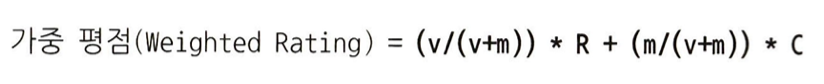

- v: 개별 영화에 평점을 투표한 횟수
  - movies_df의 'vote_count' 값
- m: 평점을 부여하기 위한 최소 투표 횟수
  - 투표 횟수에 대한 가중치를 직접 조절하는 역할
  - m 값을 높이면 평점 투표 횟수가 많은 영화에 더 많은 가중 평점을 부여
  - m 값은 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 정함
  - 상위 60% 값은 Series 객체의 quantile()을 이용해 추출
- R: 개별 영화에 대한 평균 평점
  - movies_df의 'vote_average' 값
- C: 전체 영화에 대한 평균 평점
  -  movies_df['vote_average'].mean()으로 구할 수 있음

In [12]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3), 'm:',round(m,3))

C: 6.092 m: 370.2


**새로운 평점 정보 생성** <br/>
기존 평점을 새로운 가중 평점으로 변경하는 함수를 생성하고 이를 이용해 새로운 평점 정보 생성
- DataFrame의 레코드를 인자로 받아 이 레코드의 vote_count와 vote_averate 칼럼, <br/> 그리고 미리 추출된 m과 C 값을 적용해 레코드별 가중 평점을 반환
- 해당 함수를 movies_df의 apply() 함수의 인자로 입력해 가중 평점을 계산

In [13]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )   

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1) 

**새로운 평점이 높은 순으로 상위 10개의 영화 추출**

In [14]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


**새롭게 정의된 평점 기준에 따라 영화 추천** <br/>
장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤에 weighted_vote 칼럼 값이 높은 순으로 top_n 추출
- 변경된 find_sim_movie()를 이용해 다시 한번 대부와 유사한 영화를 콘텐츠 기반 필터링 방식으로 추천

In [15]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # top_n의 2배에 해당하는 쟝르 유사성이 높은 index 추출 
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
# 기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출 
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
